In [8]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
plt.style.use("seaborn-darkgrid")
np.seterr(divide='ignore');

In [9]:
tune  = 100   # number of tuning steps before we start keeping good data
cores = 4     # kaggle kernels have 4 cores, so we can use each one to run chains in parallel
eps   = 0.2   # we want prior distributions centered near, but not right at, the true value.  eps pushes the prior away from true
seed  = 42
refresh = False  
#refresh = True  # Delete & recreate any existing data
draws = 4 * tune
draws_total = draws * cores


times = np.arange(1, 15)
classes = ['S','I']
y0 = [760, 3]
N = np.sum(y0)

theta = {'beta' : 0.00237, 'alpha': 0.465}
n_theta = len(theta)



For noise=0.03 draws_total=1600 ... 

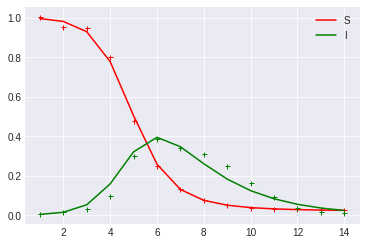

Sampling posterior


Sampling posterior_predictive


,draws,min,25%,50%,TRUE,mean,75%,max,prior_loc
sigma,1600,0.015737,0.027256,0.176720,1.00000,0.244028,0.446346,0.967869,1.109582
beta,1600,1.784999,1.812397,1.818724,1.80831,1.819059,1.825612,1.880868,2.006469
alpha,1600,0.460157,0.472499,0.475265,0.46500,0.475429,0.478235,0.502806,0.515956


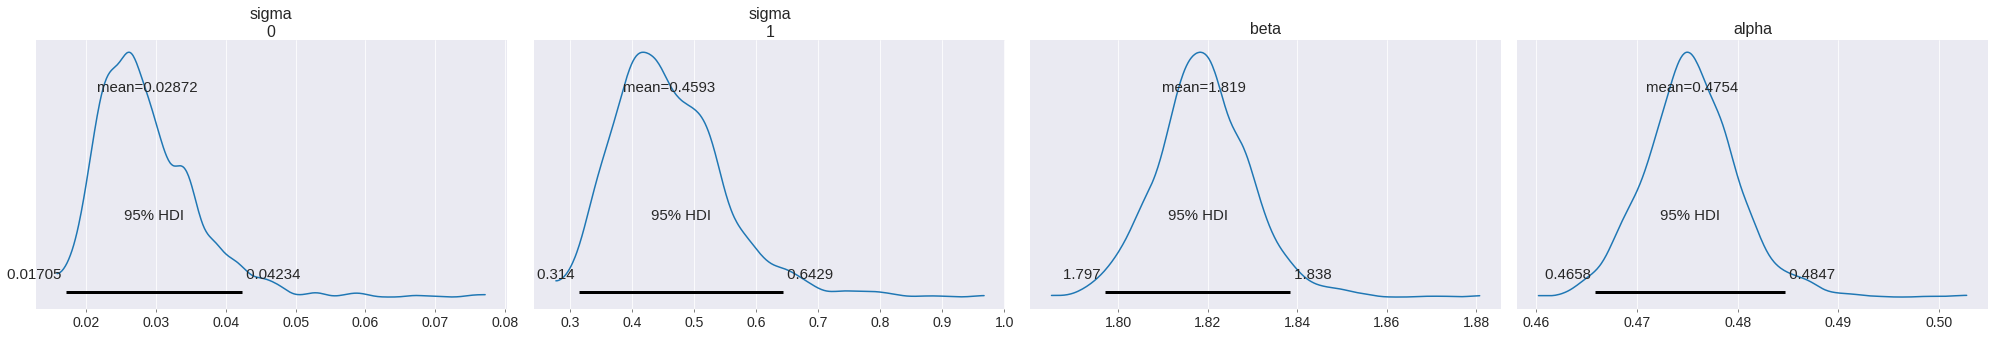

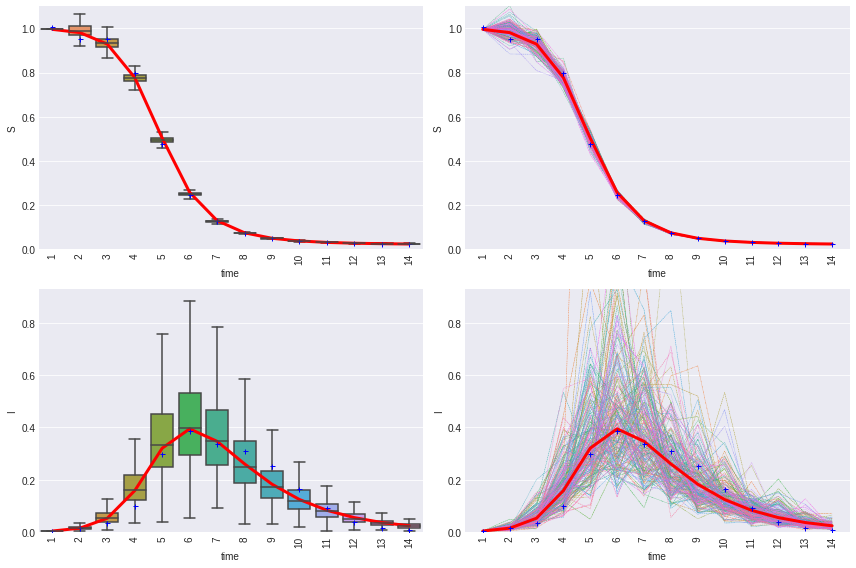

In [10]:
def SIR(y, t, p):
    ds = -p[0] * y[0] * y[1]
    di =  p[0] * y[0] * y[1] - p[1] * y[1]
    return [ds, di]

def inject_noise(noise, seed):
    """Add noise to S class predictions from odeint"""
    z = obs.copy()
    z[0] = np.random.default_rng(seed).lognormal(mean=np.log(z[0]), sigma=noise)
    return z

def plot_data(z):
    colors = ['red', 'green', 'orange', 'blue', 'yellow', 'violet']
    d = {'marker':'+', 'markersize':5, 'linestyle':''}
    for i in range(0, 2):
        clr = colors.pop(0)
        plt.plot(times, y[i], c=clr, label=classes[i])
        plt.plot(times, z[i], c=clr, label=None, **d)
    plt.legend()
    plt.show()


y = sp.integrate.odeint(SIR, y0, times, (list(theta.values()),), rtol=1e-8) 
y = y.T / N 

obs = y.copy()
obs[1, 2:] = np.array([25,75,227,296,258,236,192,126,71,28,11,7]) / N

theta_n = theta.copy()
theta_n['beta'] *= N
theta_n['sigma'] = 1.0

# guess loc for priors, but inject some error so Bayes doesn't get to start at the correct answer
theta_loc = {key: val * np.random.default_rng(seed).uniform(1-eps, 1+eps) for key,val in theta_n.items()}

# create pymc3 ODE object
ODE_pymc3 = pm.ode.DifferentialEquation(
    func=SIR,
    times=times[1:],
    t0=times[0],
    n_states=len(classes),
    n_theta=n_theta)

def make_model(z=obs):
    """Creates the pymc3 model object, but does not run it"""
    with pm.Model() as model:
        # Choose priors on alpha, beta, and sigma
        sigma_prior = pm.HalfCauchy("sigma", theta_loc['sigma'], shape=len(classes))
        params = theta_loc.copy()
        params.pop('sigma')
        theta_prior = [pm.Lognormal(key, mu=pm.math.log(loc), sigma=1.0) for key,loc in params.items()]
        curves = ODE_pymc3(y0=z.T[0], theta=theta_prior)
        Z = pm.Lognormal("Z", mu=pm.math.log(curves), sigma=sigma_prior, observed=z.T[1:])
    return model

def analyze(idata):
    """Analyzes results of pymc3 run"""
  
    theta_stats = idata.posterior.to_dataframe().describe().T 
    theta_stats['draws'] = idata.posterior.beta.size  
    theta_stats['TRUE'] = pd.Series(theta_n)          
    theta_stats['prior_loc'] = pd.Series(theta_loc)  
    theta_stats = theta_stats[['draws', 'min', '25%', '50%', 'TRUE', 'mean', '75%', 'max', 'prior_loc']]
    display(theta_stats)
    az.plot_posterior(idata, round_to=4, hdi_prob=0.95)  
    plt.show()
    
    pred = idata.posterior_predictive.to_dataframe().reset_index().rename(columns={'Z_dim_0':'time', 'Z_dim_1':'class'})
    pred['time'] += times[1] 
    pred = pred.pivot(['chain','draw','class'], 'time', 'Z') 
    t0 = times[0]
    pred[t0] = 0.0  
    pred = pred[sorted(pred.columns)] 
    r = len(classes)
    fig, axes = plt.subplots(r, 2, figsize=(12, 4*r)) 
    i = -1 
    for c, df in pred.groupby('class'): 
        i += 1
        data = df.reset_index(drop=True)
        data[t0] = y[c,0] 
        for j in range(2):  
            ax = axes[i,j]
            if j == 0:
                dt = t0
                sns.boxplot(data=data, showfliers=False, ax=ax)  
                l = max(ax.get_ylim()[0], 0.0)
                u = min(ax.get_ylim()[1], 1.1)
            elif j == 1:
               
                dt = 0
                num_plots = 200
                sns.lineplot(data=data.sample(num_plots).T, linewidth=0.5, alpha=0.9, legend=False, ax=ax) 
                
            ax.plot(times-dt, y[c], color='red' , linewidth=3)  
            ax.plot(times-dt, z[c], color='blue', marker='+', markersize=5, linestyle='') 
            ax.set_xticks(times-dt)
            ax.tick_params('x', labelrotation=90)
            ax.set_xlabel('time')
            ax.xaxis.grid(False)
            ax.yaxis.grid(True)
            ax.set_ylabel(classes[c])
            ax.set_ylim(l, u) 
    plt.tight_layout()
    plt.show()
    return theta_stats

def del_file(file):
    """ delete file if it exists"""
    try:
        os.remove(file)
    except OSError:
        pass

noises = [0.03] # noises = [0.01, 0.02, 0.05, 0.1]
for noise in sorted(noises):    
    print(f'\n\nFor noise={noise} draws_total={draws_total}', end=' ... ')
    file = f'bayes_noise={int(noise*100)%100}_draws={draws_total}.netcdf' 
    z = inject_noise(noise, seed)
    plot_data(z)
    model = make_model(z)
    with model:
        try:
            assert not refresh 
            idata = az.from_netcdf(file) 
            print(f'using idata from {file}')
        except:
            print('Sampling posterior')
            idata = pm.sample(tune=tune, draws=draws, cores=cores, chains=cores, target_accept=0.9, return_inferencedata=True)
            # save to file for reuse
            del_file(file)
            idata.to_netcdf(file)
        if not hasattr(idata, 'posterior_predictive'): 
            print('Sampling posterior_predictive')
            ppc = pm.sample_posterior_predictive(idata, keep_size=True)
            az.concat(idata, az.from_dict(posterior_predictive=ppc), inplace=True)
           
            del_file(file)
            idata.to_netcdf(file)
        analyze(idata)